In [1]:
pip install -r requirements.txt

  Using cached clip-1.0-py3-none-any.whl
  Using cached d4rl_atari-0.1-py3-none-any.whl
  Cloning https://github.com/indrasweb/expert-offline-rl.git (to revision d0e8b9dbd3bd409a8d591e63cd30b825323d3eda) to c:\users\jortv\appdata\local\temp\pip-install-mqby18_l\eorl_1329074ff32b4d73ac87e4089394c59a
  Resolved https://github.com/indrasweb/expert-offline-rl.git to commit d0e8b9dbd3bd409a8d591e63cd30b825323d3eda
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached aiohttp-3.9.1-cp39-cp39-win_amd64.whl (365 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached cryptography-38.0.4-cp36-abi3-win_amd64.whl (2.4 MB)
  Using cached dataclasses_json-0.6.4-py3-none-any.whl (28 kB)
  Using cached Flask-2.1.3-py3-none-any.whl (95 kB)
  Using cached Flask_Cors-3.0.10-py2.py3-none-any.whl (14 kB)
  Using cached Flask_SocketIO-5.3.2-py3-none-any.whl (17 kB)
  Using cached gevent-21.1.2-cp39-cp39-win_amd64.whl (1.6 MB

  Running command git clone --filter=blob:none --quiet https://github.com/indrasweb/expert-offline-rl.git 'C:\Users\jortv\AppData\Local\Temp\pip-install-mqby18_l\eorl_1329074ff32b4d73ac87e4089394c59a'
  Running command git rev-parse -q --verify 'sha^d0e8b9dbd3bd409a8d591e63cd30b825323d3eda'
  Running command git fetch -q https://github.com/indrasweb/expert-offline-rl.git d0e8b9dbd3bd409a8d591e63cd30b825323d3eda
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\jortv\\anaconda3\\Lib\\site-packages\\~orch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from tqdm import tqdm
from scipy.stats import wasserstein_distance
from model import get_data_embedding
from torch.cuda.amp import autocast, GradScaler  # For mixed precision
import logging
import random

In [3]:
def get_trajectory_embedding(model, observations, actions, rewards, is_seaquest=False, device='cpu'):
    """
    Calculates the trajectory embedding for a given model, observations, actions, and rewards.

    Args:
        model (torch.nn.Module): The model used to calculate the embedding.
        observations (list): List of observations.
        actions (list): List of actions.
        rewards (list): List of rewards.
        stack_frames_fn (function, optional): Function to stack frames for Seaquest environment. Defaults to None.
        is_seaquest (bool, optional): Flag indicating if the environment is Seaquest. Defaults to False.

    Returns:
        list: List of trajectory embeddings.
    """
    def reshape_input(observations, actions, rewards, device='cpu'):
        input_obs = observations.view(1, -1, 4*84*84).to(device)
        input_act = actions.view(1, -1, 1).to(device)
        input_rew = rewards.view(1, -1, 1).to(device)
        timesteps = torch.as_tensor([[[1]]], dtype=torch.long).to(device)  # Adjust as needed
        return input_obs, input_act, input_rew, timesteps

    model = model.to(device)
    scaler = GradScaler()
    if is_seaquest:
        input_obs, input_act, input_rew, timesteps = reshape_input(observations[0], actions[0], rewards[0], device=device)
        embedding = model(input_obs, input_act, rtgs=input_rew, timesteps=timesteps).detach()
        MAX_SIZE = torch.mean(embedding, dim=1).flatten().shape[0]
    else:
        combined_input = torch.cat([observations[0], actions[0], rewards[0].unsqueeze(1)], dim=1).type(torch.long)
        combined_input = combined_input.to(device)
        MAX_SIZE = model(combined_input).detach().flatten().shape[0]

    filename = 'seaquest_trajectory_embedding.dat' if is_seaquest else 'halfcheetah_trajectory_embedding.dat'

    trajectory_embedding = torch.zeros((len(observations), MAX_SIZE), dtype=torch.float16, device=device)

    for ind, (obs, act, rew) in enumerate(tqdm(zip(observations, actions, rewards), total=len(observations), desc="Processing trajectories")):
        with autocast():
            if is_seaquest:
                input_obs, input_act, input_rew, timesteps = reshape_input(obs, act, rew, device=device)
                embedding = model(input_obs, input_act, rtgs=input_rew, timesteps=timesteps).detach()
                embedding = torch.mean(embedding, dim=1).flatten()
            else:
                combined_input = torch.cat([obs, act, rew.unsqueeze(1)], dim=1).type(torch.long)
                combined_input = combined_input.to(device)
                embedding = model(combined_input).detach()
                embedding = torch.mean(embedding, dim=1).flatten()
            

        embedding_size = min(len(embedding), MAX_SIZE)
        trajectory_embedding[ind, :embedding_size] = embedding[:embedding_size].cpu()

    return trajectory_embedding

In [4]:
def perform_clustering_and_plot(traj_embeddings, amount_initial_centers, max_clusters, plot=True):
    """
    Performs clustering on prepared trajectory embeddings using X-Means and plots the results.

    :param traj_embeddings: Prepared trajectory embeddings.
    :param amount_initial_centers: Initial number of centers for clustering.
    :param max_clusters: Maximum number of clusters.
    :return: None
    """
    # Create a basic logger
    logger = logging.getLogger(__name__)
    logging.basicConfig(level=logging.INFO)

    logger.info('Starting clustering process.')

    # Initialize centers using kmeans_plusplus_initializer
    initial_centers = kmeans_plusplus_initializer(traj_embeddings, amount_initial_centers).initialize()

    logger.info('Initial centers initialized.')

    # Create and process X-Means instance
    xmeans_instance = xmeans(traj_embeddings, initial_centers, max_clusters)
    xmeans_instance.process()

    logger.info('X-Means instance processed.')
    
    # Extract clustering results: clusters and their centers
    clusters = xmeans_instance.get_clusters()

    logger.info('Clustering results extracted.')
    
    # Assign cluster labels to each trajectory
    traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)
    for cluster_id, cluster in enumerate(clusters):
        for traj_id in cluster:
            traj_cluster_labels[traj_id] = cluster_id

    logger.info('Cluster labels assigned to each trajectory.')

    # Perform PCA for visualization
    pca_traj = PCA(n_components=2)
    pca_traj_embeds = pca_traj.fit_transform(traj_embeddings)
    plotting_data = {
        'feature 1': pca_traj_embeds[:, 0],
        'feature 2': pca_traj_embeds[:, 1],
        'cluster id': traj_cluster_labels
    }
    df = pd.DataFrame(plotting_data)

    logger.info('PCA performed for visualization.')

    if plot:
        # Plotting
        plt.figure(figsize=(4,3))
        palette = sns.color_palette('husl', len(clusters) + 1)
        sns.scatterplot(
            x='feature 1',
            y='feature 2',
            hue='cluster id',
            palette=palette[:len(clusters)],
            data=df,
            legend=True
        )
        plt.title('Trajectory Embeddings for ' + str(amount_initial_centers) + ' initial centers')
        plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
        plt.tight_layout()
        plt.show()

        logger.info('Plot created.')

    return clusters

In [5]:
import torch
from tqdm import tqdm

def create_trajectories(observations, actions, rewards, terminals, trajectory_length):
    """
    Create trajectories from the given observations, actions, rewards, and terminals.
    Parameters:
        observations (torch.Tensor): Tensor of shape [num_frames, height, width].
        stack_size (int): Number of frames to stack for each observation.
    Returns:
        torch.Tensor: Stacked observations of shape [(num_frames-stack_size+1), stack_size, height, width].
    """
    # Efficiently compute the number of trajectories
    terminal_indices = [i for i, x in enumerate(terminals) if x]
    #print("DEBUG: terminal_indices", terminal_indices)
    padded_length = sum(trajectory_length - (i % trajectory_length) for i in terminal_indices)
    total_length = len(observations) + padded_length
    num_trajectories = total_length // trajectory_length

    # Tensor shapes
    obs_shape = observations[0].shape
    act_shape = actions[0].shape
    rew_shape = rewards[0].shape
    term_shape = terminals[0].shape

    # Pre-allocate tensors
    final_obs = torch.zeros((num_trajectories, trajectory_length, *obs_shape), dtype=torch.uint8)
    final_act = torch.zeros((num_trajectories, trajectory_length, *act_shape))
    final_rew = torch.zeros((num_trajectories, trajectory_length, *rew_shape))
    final_ter = torch.zeros((num_trajectories, trajectory_length, *term_shape))

    # Populate tensors
    trajectory_idx = 0
    step_idx = 0
    for i in tqdm(range(len(observations)), desc="Processing sub'trajectories"):
        final_obs[trajectory_idx, step_idx] = torch.from_numpy(observations[i])
        final_act[trajectory_idx, step_idx] = torch.as_tensor(actions[i])
        final_rew[trajectory_idx, step_idx] = torch.as_tensor(rewards[i])
        final_ter[trajectory_idx, step_idx] = torch.as_tensor(terminals[i])
        step_idx += 1

        if terminals[i] or step_idx == trajectory_length:
            trajectory_idx += 1
            step_idx = 0
            if trajectory_idx >= num_trajectories:
                break


    return final_obs, final_act, final_rew, final_ter


In [6]:
from makeSeaquestdata import load_seaquest_dataset

data_size = 200
test_size = 10
seaquestdata, sq_env = load_seaquest_dataset(env_name='Breakout', size=data_size+test_size)

decompressing data...
Dataset loaded
261419
Dataset extracted with 261419 samples.
Information about the dataset:
Observation shape:  (261419, 4, 84, 84)
Action shape:  (261419,)
Reward shape:  (261419,)
Terminal shape:  (261419,)
Action space:  4
Observation space:  (84, 84)
Number of terminal states is... 209
Environment 'ALE/Breakout-ram-v5' initialized.


In [7]:
terminal_indexes = np.where(seaquestdata['terminals'] == True)[0]
trunc = terminal_indexes[-test_size]
terminal_indexes = terminal_indexes[data_size:] # Get index of first trajectory that we want to draw

test_observations = []
test_actions = []
for i in range(len(terminal_indexes)):
    ind = [i + np.random.randint(200, 300)]
    test_observations.append(seaquestdata['observations'][ind])
    test_actions.append(seaquestdata['actions'][ind][0])

In [8]:
import copy

In [9]:
observation = copy.deepcopy(test_observations[0])

# Observation has shape (1, 4, 84, 84)
# We need to remove the first dimension
# and plot each channel separately
observation = observation.squeeze()
print("Observation Shape:", observation.shape)
print('Test observation shape: ', test_observations[0].shape)

# assert test_observations[0].shape == (1, 4, 84, 84)
# if not, drop the first dimension
if test_observations[0].shape != (1, 4, 84, 84):
    test_observations[0] = test_observations[0].squeeze()
    print('Test observation shape after squeezing: ', test_observations[0].shape)


# Remove all the previous observations, actions, rewards and terminals
seaquestdata["observations"] = seaquestdata["observations"][:trunc]
seaquestdata["actions"] = seaquestdata["actions"][:trunc]
seaquestdata["rewards"] = seaquestdata["rewards"][:trunc]
seaquestdata["terminals"] = seaquestdata["terminals"][:trunc]

Observation Shape: (4, 84, 84)
Test observation shape:  (1, 4, 84, 84)


In [10]:
from load_model import load_seaquest_model
pre_trained_encoder_seaquest = load_seaquest_model("decision_transformer_atari/checkpoints/Breakout_123.pth")

In [11]:
final_obs_sq, final_act_sq, final_rew_sq, _ = create_trajectories(
        seaquestdata["observations"], seaquestdata["actions"], 
        seaquestdata["rewards"], seaquestdata["terminals"], trajectory_length=30
    )

Processing sub'trajectories: 100%|█████████▉| 249926/249952 [00:08<00:00, 28162.63it/s]


In [12]:
final_obs_sq.shape

torch.Size([8428, 30, 4, 84, 84])

In [13]:
final_obs_sq[0].shape, final_act_sq[0], final_rew_sq[0]

(torch.Size([30, 4, 84, 84]),
 tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [14]:
device = 'cpu'

In [15]:
trajectory_embedding_seaquest = get_trajectory_embedding(
        pre_trained_encoder_seaquest, final_obs_sq, final_act_sq, final_rew_sq, 
        is_seaquest=True, device= device
    )

c:\Users\jortv\anaconda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Processing trajectories:   0%|          | 0/8428 [00:00<?, ?it/s]c:\Users\jortv\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Processing trajectories: 100%|██████████| 8428/8428 [01:56<00:00, 72.49it/s]


In [16]:
clusters_seaquest = perform_clustering_and_plot(trajectory_embedding_seaquest.detach().cpu(), 2, 8, plot=False)

In [17]:
from d3rlpy.dataset import Episode 
import d3rlpy
from encoder import CustomCNNFactory
import torch
import numpy as np

def make_episodes(final_obs, final_act, final_rew, max_action_values):
    list_episodes = []
    for i in range(len(final_obs)):
        list_episodes.append(Episode(final_obs[i].numpy().shape[1:], max_action_values, final_obs[i].numpy(), final_act[i].numpy(), final_rew[i].numpy()))
    return list_episodes

In [18]:
list_episodes_sq = make_episodes(final_obs_sq, final_act_sq, final_rew_sq, 4)

In [19]:
def fit_discrete_sac(list_episodes, n_steps=1000, n_steps_per_epoch=100, device='cpu'):
    cuda_check = True if device == 'cuda' else False
    feature_size = 128
    custom_encoder_actor = CustomCNNFactory(feature_size)
    custom_encoder_critic = CustomCNNFactory(feature_size)

    # Train an agent on the new data
    sac_sq = d3rlpy.algos.DiscreteSAC(
            actor_learning_rate=3e-4,
            critic_learning_rate=3e-4,
            temp_learning_rate=3e-4,
            batch_size=256,
            actor_encoder_factory= custom_encoder_actor,
            critic_encoder_factory= custom_encoder_critic,
            scaler='pixel',
            target_update_interval=2500,
            use_gpu=cuda_check)
    
    sac_sq.fit(list_episodes, n_steps=n_steps, n_steps_per_epoch=n_steps_per_epoch)

    return sac_sq

In [20]:
sac_sq = fit_discrete_sac(list_episodes_sq, n_steps=100, n_steps_per_epoch=10, device=device)

2024-04-17 10:33:02 [debug    ] RandomIterator is selected.
2024-04-17 10:33:02 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240417103302
2024-04-17 10:33:02 [debug    ] Fitting scaler...              scaler=pixel
2024-04-17 10:33:02 [debug    ] Building models...
2024-04-17 10:33:03 [debug    ] Models have been built.
2024-04-17 10:33:03 [info     ] Parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103302\params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 0.0001, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'critic_learning_rate': 0.0003, 'critic_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 0.0001, 'weight_decay': 0, 'amsgrad': False}, 'gamma': 0.99, 'generated_maxlen': 100000,

Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:05 [info     ] DiscreteSAC_20240417103302: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.006060934066772461, 'time_algorithm_update': 0.22770466804504394, 'temp_loss': 0.027397373132407664, 'temp': 0.9983582913875579, 'critic_loss': 1.5251835823059081, 'actor_loss': -1.558617615699768, 'time_step': 0.23386678695678711} step=10
2024-04-17 10:33:05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103302\model_10.pt


Epoch 2/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:07 [info     ] DiscreteSAC_20240417103302: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.005866432189941406, 'time_algorithm_update': 0.21442170143127443, 'temp_loss': 0.0207118459045887, 'temp': 0.9954169034957886, 'critic_loss': 0.4407074302434921, 'actor_loss': -2.5702420473098755, 'time_step': 0.22043020725250245} step=20
2024-04-17 10:33:07 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103302\model_20.pt


Epoch 3/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:10 [info     ] DiscreteSAC_20240417103302: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.00621645450592041, 'time_algorithm_update': 0.21366345882415771, 'temp_loss': 0.022455618530511857, 'temp': 0.9927663683891297, 'critic_loss': 0.17468545883893966, 'actor_loss': -2.4712260246276854, 'time_step': 0.2199880838394165} step=30
2024-04-17 10:33:10 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103302\model_30.pt


Epoch 4/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:12 [info     ] DiscreteSAC_20240417103302: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.005826330184936524, 'time_algorithm_update': 0.21544873714447021, 'temp_loss': 0.02735161781311035, 'temp': 0.9899348676204681, 'critic_loss': 0.1289918005466461, 'actor_loss': -2.763782501220703, 'time_step': 0.22137596607208251} step=40
2024-04-17 10:33:12 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103302\model_40.pt


Epoch 5/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:14 [info     ] DiscreteSAC_20240417103302: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.006138825416564941, 'time_algorithm_update': 0.2201845169067383, 'temp_loss': 0.027350340224802493, 'temp': 0.986874794960022, 'critic_loss': 0.10017735213041305, 'actor_loss': -2.66777503490448, 'time_step': 0.22642407417297364} step=50
2024-04-17 10:33:14 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103302\model_50.pt


Epoch 6/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:16 [info     ] DiscreteSAC_20240417103302: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.005988788604736328, 'time_algorithm_update': 0.21206119060516357, 'temp_loss': 0.027276968210935594, 'temp': 0.9837717294692994, 'critic_loss': 0.10489687025547027, 'actor_loss': -2.7336156368255615, 'time_step': 0.21815221309661864} step=60
2024-04-17 10:33:16 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103302\model_60.pt


Epoch 7/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:19 [info     ] DiscreteSAC_20240417103302: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.005994057655334473, 'time_algorithm_update': 0.21380574703216554, 'temp_loss': 0.027194756641983987, 'temp': 0.9806840181350708, 'critic_loss': 0.10354412347078323, 'actor_loss': -2.7293471097946167, 'time_step': 0.2197998046875} step=70
2024-04-17 10:33:19 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103302\model_70.pt


Epoch 8/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:21 [info     ] DiscreteSAC_20240417103302: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.006017947196960449, 'time_algorithm_update': 0.21819021701812744, 'temp_loss': 0.027109395153820513, 'temp': 0.9776259005069733, 'critic_loss': 0.10441152229905129, 'actor_loss': -2.716794753074646, 'time_step': 0.22430915832519532} step=80
2024-04-17 10:33:21 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103302\model_80.pt


Epoch 9/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:23 [info     ] DiscreteSAC_20240417103302: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.0059200763702392575, 'time_algorithm_update': 0.21775565147399903, 'temp_loss': 0.0270247969776392, 'temp': 0.9745988070964813, 'critic_loss': 0.10852257758378983, 'actor_loss': -2.7228397369384765, 'time_step': 0.223876953125} step=90
2024-04-17 10:33:23 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103302\model_90.pt


Epoch 10/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:26 [info     ] DiscreteSAC_20240417103302: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.0061062097549438475, 'time_algorithm_update': 0.2271578311920166, 'temp_loss': 0.026944111846387387, 'temp': 0.9716005027294159, 'critic_loss': 0.08843926712870598, 'actor_loss': -2.7124982357025145, 'time_step': 0.23336405754089357} step=100
2024-04-17 10:33:26 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103302\model_100.pt


In [21]:
action_dict = {0: 'NOOP', 1: 'FIRE', 2: 'RIGHT', 3: 'LEFT'}

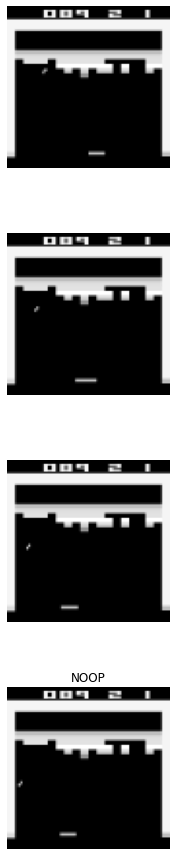

In [22]:
plt.figure(figsize=(10, 12))  # Adjust the figure size
for i in range(4):
    plt.subplot(4, 1, i + 1)
    plt.imshow(observation[i], cmap='gray')
    plt.axis('off')
    plt.tight_layout()

    if i == 3:
        action = sac_sq.predict(np.expand_dims(observation, axis=0))
        plt.title(action_dict[action[0]])

plt.subplots_adjust(hspace=0.4)  # Adjust the vertical spacing
plt.savefig('test_observation_stack.png')

In [23]:
feature_size = 128
custom_encoder_actor = CustomCNNFactory(feature_size)
custom_encoder_critic = CustomCNNFactory(feature_size)

model_params_sq = {
'actor_learning_rate': 3e-4,
'critic_learning_rate': 3e-4,
'temp_learning_rate': 3e-4,
'batch_size': 256,
'actor_encoder_factory': custom_encoder_actor,
'critic_encoder_factory': custom_encoder_critic,
'scaler': 'pixel',
'use_gpu': True if device == 'cuda' else False
}

In [24]:
def fit_per_cluster(model, 
                    model_class, 
                    model_params, 
                    data_embedding, 
                    list_episodes, 
                    clusters, 
                    trajectory_embedding, 
                    test_observations):
    
    original_actions = []
    original_action_values = []
    for t in test_observations:
        action = model.predict(t)
        print("Original model action: ", action)
        action_value = model.predict_value(t, action = action)
        print("Original model action value: ", action_value)
        print("Passing: ", action[0], action_value[0])
        original_actions.append(action[0])
        original_action_values.append(action_value[0])

    result_data_combinations = {0:(original_actions, original_action_values, get_data_embedding(data_embedding))} # Original dataset policy
    models = {0:(model, get_data_embedding(data_embedding))}
    
    for cluster_id, cluster in enumerate(clusters):
        model = model_class(**model_params)
        count_in_clusters = 0
        count_not_in_clusters = 0
        temp_data = []
        temp_traj_embeds = []
        temp_cluster_traj_embeds = []
        for traj_id, traj in enumerate(list_episodes):
            if traj_id not in cluster:
                temp_data.append(list_episodes[traj_id])
                temp_traj_embeds.append(trajectory_embedding[traj_id])
                count_not_in_clusters += 1
            else:
                temp_cluster_traj_embeds.append(trajectory_embedding[traj_id])
                count_in_clusters += 1
        print('-'*100)
        print(f'Cluster {cluster_id + 1} has {count_in_clusters} trajectories out of {count_not_in_clusters + count_in_clusters}')
        print('-'*100)
        
        # Generate the data embedding
        data_embedding_new = get_data_embedding(temp_traj_embeds)
        # Train an agent on the new data
        model.fit(temp_data, n_steps=100, n_steps_per_epoch=10)

        models[cluster_id + 1] = (model, data_embedding_new)

        new_actions = []
        new_action_values = []
        for t in test_observations:
            action = model.predict(t)
            print("New model action: ", action)
            action_value = model.predict_value(t, action = action)
            print("New model action value: ", action_value)
            print("Passing: ", action[0], action_value[0])

            new_actions.append(action[0])
            new_action_values.append(action_value[0])
        
        result_data_combinations[cluster_id + 1] = (new_actions, new_action_values, data_embedding_new) # Clustered dataset policy (cluster_id + 1 because 0 is the original dataset)
                                                                                    # so each value is the model trained on original data - cluster 1, original data - cluster 2, etc.
        
    return models, result_data_combinations

In [25]:
def get_data_embedding(traj_embeddings):
    # Convert to numpy arrays if the embeddings are PyTorch tensors
    if isinstance(traj_embeddings[0], torch.Tensor):
        #traj_embeddings = traj_embeddings
        traj_embeddings = [te.cpu().numpy() for te in traj_embeddings]

    # Compute the sum of the embeddings, dividing by 10
    summed_embeddings = np.array(traj_embeddings).sum(axis=0) / 10.0

    # Apply softmax to the summed embeddings
    max_embeddings = np.max(summed_embeddings)
    exp_embeddings = np.exp(summed_embeddings - max_embeddings)
    softmax_embeddings = exp_embeddings / np.sum(exp_embeddings, axis=0)

    return softmax_embeddings

In [26]:
models_sq, result_data_combinations_sq = fit_per_cluster(
        model= sac_sq, 
        model_class = d3rlpy.algos.DiscreteSAC,
        model_params=model_params_sq,
        data_embedding=trajectory_embedding_seaquest,
        list_episodes=list_episodes_sq,
        clusters=clusters_seaquest,
        trajectory_embedding=trajectory_embedding_seaquest,
        test_observations=test_observations)

Original model action:  [0]
Original model action value:  [1.3126738]
Passing:  0 1.3126738
Original model action:  [0]
Original model action value:  [1.3230234]
Passing:  0 1.3230234
Original model action:  [0]
Original model action value:  [1.3127649]
Passing:  0 1.3127649
Original model action:  [0]
Original model action value:  [1.318299]
Passing:  0 1.318299
Original model action:  [0]
Original model action value:  [1.3232656]
Passing:  0 1.3232656
Original model action:  [0]
Original model action value:  [1.3178558]
Passing:  0 1.3178558
Original model action:  [0]
Original model action value:  [1.3180344]
Passing:  0 1.3180344
Original model action:  [0]
Original model action value:  [1.3241818]
Passing:  0 1.3241818
Original model action:  [0]
Original model action value:  [1.3170295]
Passing:  0 1.3170295
----------------------------------------------------------------------------------------------------
Cluster 1 has 1127 trajectories out of 8428
-----------------------------

Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:29 [info     ] DiscreteSAC_20240417103326: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.006104660034179687, 'time_algorithm_update': 0.2380064010620117, 'temp_loss': 0.027437980100512505, 'temp': 0.9983582615852356, 'critic_loss': 1.4349094748497009, 'actor_loss': -1.46812961101532, 'time_step': 0.24421195983886718} step=10
2024-04-17 10:33:29 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103326\model_10.pt


Epoch 2/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:31 [info     ] DiscreteSAC_20240417103326: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.006387591361999512, 'time_algorithm_update': 0.23977987766265868, 'temp_loss': 0.018571887351572513, 'temp': 0.9954305827617645, 'critic_loss': 0.35090611800551413, 'actor_loss': -2.505407452583313, 'time_step': 0.24626920223236085} step=20
2024-04-17 10:33:31 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103326\model_20.pt


Epoch 3/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:34 [info     ] DiscreteSAC_20240417103326: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.006345486640930176, 'time_algorithm_update': 0.2346583127975464, 'temp_loss': 0.02122346218675375, 'temp': 0.9929143011569976, 'critic_loss': 0.17229587435722352, 'actor_loss': -2.402968978881836, 'time_step': 0.24100379943847655} step=30
2024-04-17 10:33:34 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103326\model_30.pt


Epoch 4/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:36 [info     ] DiscreteSAC_20240417103326: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.005945372581481934, 'time_algorithm_update': 0.22533056735992432, 'temp_loss': 0.027134357206523418, 'temp': 0.990156602859497, 'critic_loss': 0.11420271545648575, 'actor_loss': -2.660719561576843, 'time_step': 0.2313779354095459} step=40
2024-04-17 10:33:36 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103326\model_40.pt


Epoch 5/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:38 [info     ] DiscreteSAC_20240417103326: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.006138110160827636, 'time_algorithm_update': 0.2233503580093384, 'temp_loss': 0.027259293384850024, 'temp': 0.9870917856693268, 'critic_loss': 0.09863273948431014, 'actor_loss': -2.581287693977356, 'time_step': 0.2296903371810913} step=50
2024-04-17 10:33:38 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103326\model_50.pt


Epoch 6/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:41 [info     ] DiscreteSAC_20240417103326: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.005951714515686035, 'time_algorithm_update': 0.22556209564208984, 'temp_loss': 0.02719543632119894, 'temp': 0.9839602828025817, 'critic_loss': 0.1013544663786888, 'actor_loss': -2.6140514373779298, 'time_step': 0.231614351272583} step=60
2024-04-17 10:33:41 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103326\model_60.pt


Epoch 7/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:43 [info     ] DiscreteSAC_20240417103326: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.005921578407287598, 'time_algorithm_update': 0.22506039142608641, 'temp_loss': 0.027138507552444936, 'temp': 0.9808399617671967, 'critic_loss': 0.0992078274488449, 'actor_loss': -2.6211325407028196, 'time_step': 0.23108282089233398} step=70
2024-04-17 10:33:43 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103326\model_70.pt


Epoch 8/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:46 [info     ] DiscreteSAC_20240417103326: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.006091260910034179, 'time_algorithm_update': 0.23689801692962648, 'temp_loss': 0.02706179078668356, 'temp': 0.9777502059936524, 'critic_loss': 0.08138315677642823, 'actor_loss': -2.6270041704177856, 'time_step': 0.24309020042419432} step=80
2024-04-17 10:33:46 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103326\model_80.pt


Epoch 9/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:48 [info     ] DiscreteSAC_20240417103326: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.005951642990112305, 'time_algorithm_update': 0.22889652252197265, 'temp_loss': 0.02697045188397169, 'temp': 0.9746942698955536, 'critic_loss': 0.0998507633805275, 'actor_loss': -2.622985672950745, 'time_step': 0.23495173454284668} step=90
2024-04-17 10:33:48 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103326\model_90.pt


Epoch 10/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:50 [info     ] DiscreteSAC_20240417103326: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.005935835838317871, 'time_algorithm_update': 0.22701587677001953, 'temp_loss': 0.026883770152926444, 'temp': 0.9716706931591034, 'critic_loss': 0.08011746108531952, 'actor_loss': -2.6377694845199584, 'time_step': 0.23305258750915528} step=100
2024-04-17 10:33:50 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103326\model_100.pt
New model action:  [0]
New model action value:  [1.2170326]
Passing:  0 1.2170326
New model action:  [0]
New model action value:  [1.2287663]
Passing:  0 1.2287663
New model action:  [0]
New model action value:  [1.2185471]
Passing:  0 1.2185471
New model action:  [0]
New model action value:  [1.2213306]
Passing:  0 1.2213306
New model action:  [0]
New model action value:  [1.2303205]
Passing:  0 1.2303205
New model action:  [0]
New model action value:  [1.2221825]
Passing:  0 1.2221825
New model action:  [0]
New model

Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:53 [info     ] DiscreteSAC_20240417103350: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.0058694124221801754, 'time_algorithm_update': 0.2317570209503174, 'temp_loss': 0.027142048813402653, 'temp': 0.9983571410179138, 'critic_loss': 1.384006142616272, 'actor_loss': -1.5404062509536742, 'time_step': 0.23762643337249756} step=10
2024-04-17 10:33:53 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103350\model_10.pt


Epoch 2/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:55 [info     ] DiscreteSAC_20240417103350: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.0058770418167114254, 'time_algorithm_update': 0.22480523586273193, 'temp_loss': 0.02514750249683857, 'temp': 0.995399284362793, 'critic_loss': 0.2729321107268333, 'actor_loss': -2.6498748302459716, 'time_step': 0.2307830810546875} step=20
2024-04-17 10:33:55 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103350\model_20.pt


Epoch 3/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:33:58 [info     ] DiscreteSAC_20240417103350: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.005864477157592774, 'time_algorithm_update': 0.22920596599578857, 'temp_loss': 0.02714497223496437, 'temp': 0.9924666345119476, 'critic_loss': 0.15643481090664862, 'actor_loss': -2.4118282556533814, 'time_step': 0.2352830648422241} step=30
2024-04-17 10:33:58 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103350\model_30.pt


Epoch 4/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:00 [info     ] DiscreteSAC_20240417103350: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.005852270126342774, 'time_algorithm_update': 0.23538720607757568, 'temp_loss': 0.026983722858130933, 'temp': 0.989487475156784, 'critic_loss': 0.13894156590104104, 'actor_loss': -2.6257520437240602, 'time_step': 0.2413403034210205} step=40
2024-04-17 10:34:00 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103350\model_40.pt


Epoch 5/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:03 [info     ] DiscreteSAC_20240417103350: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.0059692621231079105, 'time_algorithm_update': 0.23470661640167237, 'temp_loss': 0.02703671008348465, 'temp': 0.9865061819553376, 'critic_loss': 0.10045485049486161, 'actor_loss': -2.591352605819702, 'time_step': 0.24067587852478028} step=50
2024-04-17 10:34:03 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103350\model_50.pt


Epoch 6/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:05 [info     ] DiscreteSAC_20240417103350: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.0062035322189331055, 'time_algorithm_update': 0.23677313327789307, 'temp_loss': 0.02712097056210041, 'temp': 0.983530867099762, 'critic_loss': 0.09774958863854408, 'actor_loss': -2.6183969974517822, 'time_step': 0.24307751655578613} step=60
2024-04-17 10:34:05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103350\model_60.pt


Epoch 7/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:07 [info     ] DiscreteSAC_20240417103350: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.005910253524780274, 'time_algorithm_update': 0.23192906379699707, 'temp_loss': 0.027089320495724677, 'temp': 0.980563884973526, 'critic_loss': 0.09419217109680175, 'actor_loss': -2.636429238319397, 'time_step': 0.23794009685516357} step=70
2024-04-17 10:34:07 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103350\model_70.pt


Epoch 8/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:10 [info     ] DiscreteSAC_20240417103350: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.005995464324951172, 'time_algorithm_update': 0.22846226692199706, 'temp_loss': 0.027006246708333494, 'temp': 0.9776104688644409, 'critic_loss': 0.09001797437667847, 'actor_loss': -2.608212876319885, 'time_step': 0.23468232154846191} step=80
2024-04-17 10:34:10 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103350\model_80.pt


Epoch 9/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:12 [info     ] DiscreteSAC_20240417103350: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.005669045448303223, 'time_algorithm_update': 0.23254740238189697, 'temp_loss': 0.02688020244240761, 'temp': 0.9746748030185699, 'critic_loss': 0.08837411627173423, 'actor_loss': -2.6117326736450197, 'time_step': 0.23831825256347655} step=90
2024-04-17 10:34:12 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103350\model_90.pt


Epoch 10/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:15 [info     ] DiscreteSAC_20240417103350: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.005751848220825195, 'time_algorithm_update': 0.23080718517303467, 'temp_loss': 0.026779940724372862, 'temp': 0.9717591941356659, 'critic_loss': 0.08777923844754695, 'actor_loss': -2.613083815574646, 'time_step': 0.23655903339385986} step=100
2024-04-17 10:34:15 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103350\model_100.pt
New model action:  [0]
New model action value:  [1.2207109]
Passing:  0 1.2207109
New model action:  [0]
New model action value:  [1.2357492]
Passing:  0 1.2357492
New model action:  [0]
New model action value:  [1.2214825]
Passing:  0 1.2214825
New model action:  [0]
New model action value:  [1.2261906]
Passing:  0 1.2261906
New model action:  [0]
New model action value:  [1.2350333]
Passing:  0 1.2350333
New model action:  [0]
New model action value:  [1.227526]
Passing:  0 1.227526
New model action:  [0]
New model ac

Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:17 [info     ] DiscreteSAC_20240417103415: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.005425786972045899, 'time_algorithm_update': 0.23517913818359376, 'temp_loss': 0.026851133070886136, 'temp': 0.9983553290367126, 'critic_loss': 1.3799733996391297, 'actor_loss': -1.5556665897369384, 'time_step': 0.24070489406585693} step=10
2024-04-17 10:34:17 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103415\model_10.pt


Epoch 2/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:20 [info     ] DiscreteSAC_20240417103415: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.005602574348449707, 'time_algorithm_update': 0.22411811351776123, 'temp_loss': 0.022189244255423547, 'temp': 0.995412927865982, 'critic_loss': 0.2815194815397263, 'actor_loss': -2.71629114151001, 'time_step': 0.23003876209259033} step=20
2024-04-17 10:34:20 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103415\model_20.pt


Epoch 3/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:22 [info     ] DiscreteSAC_20240417103415: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.005652117729187012, 'time_algorithm_update': 0.23163068294525146, 'temp_loss': 0.02568253129720688, 'temp': 0.9925621092319489, 'critic_loss': 0.1561194248497486, 'actor_loss': -2.4700405836105346, 'time_step': 0.23739476203918458} step=30
2024-04-17 10:34:22 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103415\model_30.pt


Epoch 4/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:24 [info     ] DiscreteSAC_20240417103415: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.005814599990844727, 'time_algorithm_update': 0.22668373584747314, 'temp_loss': 0.026506276242434977, 'temp': 0.989597600698471, 'critic_loss': 0.12370531782507896, 'actor_loss': -2.726412463188171, 'time_step': 0.23259823322296141} step=40
2024-04-17 10:34:24 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103415\model_40.pt


Epoch 5/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:27 [info     ] DiscreteSAC_20240417103415: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.005550694465637207, 'time_algorithm_update': 0.22771944999694824, 'temp_loss': 0.026676811277866364, 'temp': 0.9865747094154358, 'critic_loss': 0.10295042917132377, 'actor_loss': -2.6293378353118895, 'time_step': 0.23347001075744628} step=50
2024-04-17 10:34:27 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103415\model_50.pt


Epoch 6/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:29 [info     ] DiscreteSAC_20240417103415: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.0057285547256469725, 'time_algorithm_update': 0.23007097244262695, 'temp_loss': 0.02685385923832655, 'temp': 0.983541077375412, 'critic_loss': 0.10700538903474807, 'actor_loss': -2.677020239830017, 'time_step': 0.2359003782272339} step=60
2024-04-17 10:34:29 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103415\model_60.pt


Epoch 7/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:32 [info     ] DiscreteSAC_20240417103415: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.005343198776245117, 'time_algorithm_update': 0.22802019119262695, 'temp_loss': 0.027011860348284244, 'temp': 0.9805104672908783, 'critic_loss': 0.09657211527228356, 'actor_loss': -2.680004668235779, 'time_step': 0.2334644079208374} step=70
2024-04-17 10:34:32 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103415\model_70.pt


Epoch 8/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:34 [info     ] DiscreteSAC_20240417103415: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.005665397644042969, 'time_algorithm_update': 0.223868727684021, 'temp_loss': 0.027067856676876546, 'temp': 0.9774877548217773, 'critic_loss': 0.09371596798300744, 'actor_loss': -2.636703085899353, 'time_step': 0.229666805267334} step=80
2024-04-17 10:34:34 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103415\model_80.pt


Epoch 9/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:36 [info     ] DiscreteSAC_20240417103415: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.005584812164306641, 'time_algorithm_update': 0.23414371013641358, 'temp_loss': 0.0269839508458972, 'temp': 0.9744803249835968, 'critic_loss': 0.09189656972885132, 'actor_loss': -2.6720263004302978, 'time_step': 0.23982844352722169} step=90
2024-04-17 10:34:36 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103415\model_90.pt


Epoch 10/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:39 [info     ] DiscreteSAC_20240417103415: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.005571484565734863, 'time_algorithm_update': 0.22652721405029297, 'temp_loss': 0.026915791817009448, 'temp': 0.9714950859546662, 'critic_loss': 0.08699050471186638, 'actor_loss': -2.6448173046112062, 'time_step': 0.23220016956329345} step=100
2024-04-17 10:34:39 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103415\model_100.pt
New model action:  [0]
New model action value:  [1.2683322]
Passing:  0 1.2683322
New model action:  [0]
New model action value:  [1.2797351]
Passing:  0 1.2797351
New model action:  [0]
New model action value:  [1.2678324]
Passing:  0 1.2678324
New model action:  [0]
New model action value:  [1.2744722]
Passing:  0 1.2744722
New model action:  [0]
New model action value:  [1.2828037]
Passing:  0 1.2828037
New model action:  [0]
New model action value:  [1.2745337]
Passing:  0 1.2745337
New model action:  [0]
New model

Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:42 [info     ] DiscreteSAC_20240417103439: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.005923032760620117, 'time_algorithm_update': 0.24259393215179442, 'temp_loss': 0.02705246564000845, 'temp': 0.9983574867248535, 'critic_loss': 1.3665852665901184, 'actor_loss': -1.5316457629203797, 'time_step': 0.2486194372177124} step=10
2024-04-17 10:34:42 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103439\model_10.pt


Epoch 2/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:44 [info     ] DiscreteSAC_20240417103439: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.006140708923339844, 'time_algorithm_update': 0.23897848129272461, 'temp_loss': 0.019417191669344903, 'temp': 0.9954215824604035, 'critic_loss': 0.333871902525425, 'actor_loss': -2.487123489379883, 'time_step': 0.24523096084594725} step=20
2024-04-17 10:34:44 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103439\model_20.pt


Epoch 3/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:47 [info     ] DiscreteSAC_20240417103439: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.006046843528747558, 'time_algorithm_update': 0.23608851432800293, 'temp_loss': 0.019071864429861307, 'temp': 0.9928964912891388, 'critic_loss': 0.1636686146259308, 'actor_loss': -2.5083972930908205, 'time_step': 0.2423705577850342} step=30
2024-04-17 10:34:47 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103439\model_30.pt


Epoch 4/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:49 [info     ] DiscreteSAC_20240417103439: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.0057032108306884766, 'time_algorithm_update': 0.2344597101211548, 'temp_loss': 0.027030160650610924, 'temp': 0.9901870310306549, 'critic_loss': 0.129274445772171, 'actor_loss': -2.6463662147521974, 'time_step': 0.24027202129364014} step=40
2024-04-17 10:34:49 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103439\model_40.pt


Epoch 5/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:51 [info     ] DiscreteSAC_20240417103439: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.005595517158508301, 'time_algorithm_update': 0.23402934074401854, 'temp_loss': 0.027084716595709324, 'temp': 0.9871176958084107, 'critic_loss': 0.11148888468742371, 'actor_loss': -2.633081889152527, 'time_step': 0.23973219394683837} step=50
2024-04-17 10:34:51 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103439\model_50.pt


Epoch 6/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:54 [info     ] DiscreteSAC_20240417103439: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.0057689428329467775, 'time_algorithm_update': 0.23627903461456298, 'temp_loss': 0.027051774226129054, 'temp': 0.9839678347110749, 'critic_loss': 0.09383444637060165, 'actor_loss': -2.61886351108551, 'time_step': 0.2421485662460327} step=60
2024-04-17 10:34:54 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103439\model_60.pt


Epoch 7/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:56 [info     ] DiscreteSAC_20240417103439: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.006001949310302734, 'time_algorithm_update': 0.23461802005767823, 'temp_loss': 0.027031242847442627, 'temp': 0.9808259606361389, 'critic_loss': 0.09011100567877292, 'actor_loss': -2.6497873067855835, 'time_step': 0.24061996936798097} step=70
2024-04-17 10:34:56 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103439\model_70.pt


Epoch 8/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:34:59 [info     ] DiscreteSAC_20240417103439: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.006072425842285156, 'time_algorithm_update': 0.23033413887023926, 'temp_loss': 0.026974911242723464, 'temp': 0.9777142405509949, 'critic_loss': 0.09703924730420113, 'actor_loss': -2.66053729057312, 'time_step': 0.23651275634765626} step=80
2024-04-17 10:34:59 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103439\model_80.pt


Epoch 9/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:01 [info     ] DiscreteSAC_20240417103439: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.005936455726623535, 'time_algorithm_update': 0.23468394279479982, 'temp_loss': 0.026901305466890336, 'temp': 0.9746369957923889, 'critic_loss': 0.09699606448411942, 'actor_loss': -2.629241442680359, 'time_step': 0.24062039852142333} step=90
2024-04-17 10:35:01 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103439\model_90.pt


Epoch 10/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:04 [info     ] DiscreteSAC_20240417103439: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.006149840354919433, 'time_algorithm_update': 0.23164000511169433, 'temp_loss': 0.026820973865687846, 'temp': 0.9715931832790374, 'critic_loss': 0.087068622559309, 'actor_loss': -2.636566662788391, 'time_step': 0.23788986206054688} step=100
2024-04-17 10:35:04 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103439\model_100.pt
New model action:  [0]
New model action value:  [1.2806368]
Passing:  0 1.2806368
New model action:  [0]
New model action value:  [1.2914636]
Passing:  0 1.2914636
New model action:  [0]
New model action value:  [1.282212]
Passing:  0 1.282212
New model action:  [0]
New model action value:  [1.2831461]
Passing:  0 1.2831461
New model action:  [0]
New model action value:  [1.2915776]
Passing:  0 1.2915776
New model action:  [0]
New model action value:  [1.2859347]
Passing:  0 1.2859347
New model action:  [0]
New model acti

Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:06 [info     ] DiscreteSAC_20240417103504: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.005724120140075684, 'time_algorithm_update': 0.23532729148864745, 'temp_loss': 0.02685471884906292, 'temp': 0.9983581304550171, 'critic_loss': 1.4338362336158752, 'actor_loss': -1.547540044784546, 'time_step': 0.24115190505981446} step=10
2024-04-17 10:35:06 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103504\model_10.pt


Epoch 2/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:09 [info     ] DiscreteSAC_20240417103504: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.005761194229125977, 'time_algorithm_update': 0.23831241130828856, 'temp_loss': 0.015711360657587648, 'temp': 0.9954625129699707, 'critic_loss': 0.31259443014860155, 'actor_loss': -2.642609167098999, 'time_step': 0.24430396556854247} step=20
2024-04-17 10:35:09 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103504\model_20.pt


Epoch 3/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:11 [info     ] DiscreteSAC_20240417103504: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.005909132957458496, 'time_algorithm_update': 0.2319331169128418, 'temp_loss': 0.0231831768527627, 'temp': 0.9929937601089478, 'critic_loss': 0.16530347838997841, 'actor_loss': -2.4573797941207887, 'time_step': 0.23794400691986084} step=30
2024-04-17 10:35:11 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103504\model_30.pt


Epoch 4/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:14 [info     ] DiscreteSAC_20240417103504: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.005945587158203125, 'time_algorithm_update': 0.2372708797454834, 'temp_loss': 0.027305949293076993, 'temp': 0.9901590287685395, 'critic_loss': 0.13522057980298996, 'actor_loss': -2.7153592109680176, 'time_step': 0.24321646690368653} step=40
2024-04-17 10:35:14 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103504\model_40.pt


Epoch 5/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:16 [info     ] DiscreteSAC_20240417103504: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.005678915977478027, 'time_algorithm_update': 0.22867965698242188, 'temp_loss': 0.027294686809182168, 'temp': 0.987043035030365, 'critic_loss': 0.10584793016314506, 'actor_loss': -2.6482977628707887, 'time_step': 0.2343585729598999} step=50
2024-04-17 10:35:16 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103504\model_50.pt


Epoch 6/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:19 [info     ] DiscreteSAC_20240417103504: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.005528712272644043, 'time_algorithm_update': 0.23645036220550536, 'temp_loss': 0.026984012313187124, 'temp': 0.9838846921920776, 'critic_loss': 0.09365238472819329, 'actor_loss': -2.656470799446106, 'time_step': 0.24219069480895997} step=60
2024-04-17 10:35:19 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103504\model_60.pt


Epoch 7/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:21 [info     ] DiscreteSAC_20240417103504: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.0057982921600341795, 'time_algorithm_update': 0.23388278484344482, 'temp_loss': 0.026913459412753582, 'temp': 0.980757761001587, 'critic_loss': 0.09501364156603813, 'actor_loss': -2.669137120246887, 'time_step': 0.23981137275695802} step=70
2024-04-17 10:35:21 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103504\model_70.pt


Epoch 8/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:23 [info     ] DiscreteSAC_20240417103504: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.005670428276062012, 'time_algorithm_update': 0.23067967891693114, 'temp_loss': 0.02693498209118843, 'temp': 0.9776672542095184, 'critic_loss': 0.10919082313776016, 'actor_loss': -2.6496244430541993, 'time_step': 0.2364511013031006} step=80
2024-04-17 10:35:23 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103504\model_80.pt


Epoch 9/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:26 [info     ] DiscreteSAC_20240417103504: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.005553245544433594, 'time_algorithm_update': 0.2324690818786621, 'temp_loss': 0.026929964125156403, 'temp': 0.9746068179607391, 'critic_loss': 0.09238029047846794, 'actor_loss': -2.6710575103759764, 'time_step': 0.23822898864746095} step=90
2024-04-17 10:35:26 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103504\model_90.pt


Epoch 10/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:28 [info     ] DiscreteSAC_20240417103504: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.005185365676879883, 'time_algorithm_update': 0.22414040565490723, 'temp_loss': 0.026876391470432283, 'temp': 0.9715736448764801, 'critic_loss': 0.0803519144654274, 'actor_loss': -2.655301833152771, 'time_step': 0.2294257640838623} step=100
2024-04-17 10:35:28 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103504\model_100.pt
New model action:  [0]
New model action value:  [1.2294487]
Passing:  0 1.2294487
New model action:  [0]
New model action value:  [1.2416692]
Passing:  0 1.2416692
New model action:  [0]
New model action value:  [1.2290294]
Passing:  0 1.2290294
New model action:  [0]
New model action value:  [1.2320118]
Passing:  0 1.2320118
New model action:  [0]
New model action value:  [1.2427802]
Passing:  0 1.2427802
New model action:  [0]
New model action value:  [1.2333541]
Passing:  0 1.2333541
New model action:  [0]
New model ac

Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:31 [info     ] DiscreteSAC_20240417103528: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.005608272552490234, 'time_algorithm_update': 0.23320724964141845, 'temp_loss': 0.027224321477115156, 'temp': 0.998358178138733, 'critic_loss': 1.3963431477546693, 'actor_loss': -1.5146482110023498, 'time_step': 0.23911433219909667} step=10
2024-04-17 10:35:31 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103528\model_10.pt


Epoch 2/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:33 [info     ] DiscreteSAC_20240417103528: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.005241847038269043, 'time_algorithm_update': 0.22803688049316406, 'temp_loss': 0.020817396230995655, 'temp': 0.9954380691051483, 'critic_loss': 0.3230395071208477, 'actor_loss': -2.501181125640869, 'time_step': 0.23337867259979247} step=20
2024-04-17 10:35:33 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103528\model_20.pt


Epoch 3/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:36 [info     ] DiscreteSAC_20240417103528: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.005519890785217285, 'time_algorithm_update': 0.22153778076171876, 'temp_loss': 0.026069517061114312, 'temp': 0.9926554381847381, 'critic_loss': 0.17429379671812056, 'actor_loss': -2.3881238222122194, 'time_step': 0.22715566158294678} step=30
2024-04-17 10:35:36 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103528\model_30.pt


Epoch 4/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:38 [info     ] DiscreteSAC_20240417103528: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.005208635330200195, 'time_algorithm_update': 0.22042086124420165, 'temp_loss': 0.0269661832600832, 'temp': 0.9896917521953583, 'critic_loss': 0.11050574034452439, 'actor_loss': -2.6160964250564573, 'time_step': 0.22574732303619385} step=40
2024-04-17 10:35:38 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103528\model_40.pt


Epoch 5/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:40 [info     ] DiscreteSAC_20240417103528: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.0054110527038574215, 'time_algorithm_update': 0.2203472375869751, 'temp_loss': 0.02700244840234518, 'temp': 0.9866452574729919, 'critic_loss': 0.09863099828362465, 'actor_loss': -2.5851733684539795, 'time_step': 0.22595860958099365} step=50
2024-04-17 10:35:40 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103528\model_50.pt


Epoch 6/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:42 [info     ] DiscreteSAC_20240417103528: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.0056003093719482425, 'time_algorithm_update': 0.22394192218780518, 'temp_loss': 0.02705545797944069, 'temp': 0.9835916996002197, 'critic_loss': 0.09802915826439858, 'actor_loss': -2.6343738079071044, 'time_step': 0.22964260578155518} step=60
2024-04-17 10:35:42 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103528\model_60.pt


Epoch 7/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:45 [info     ] DiscreteSAC_20240417103528: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.005413675308227539, 'time_algorithm_update': 0.21913535594940187, 'temp_loss': 0.027066438272595406, 'temp': 0.9805514752864838, 'critic_loss': 0.09603403806686402, 'actor_loss': -2.6328407287597657, 'time_step': 0.22467801570892335} step=70
2024-04-17 10:35:45 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103528\model_70.pt


Epoch 8/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:47 [info     ] DiscreteSAC_20240417103528: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.0055189371109008786, 'time_algorithm_update': 0.22520718574523926, 'temp_loss': 0.02705900203436613, 'temp': 0.9775306403636932, 'critic_loss': 0.0894825991243124, 'actor_loss': -2.6190923929214476, 'time_step': 0.23093092441558838} step=80
2024-04-17 10:35:47 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103528\model_80.pt


Epoch 9/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:50 [info     ] DiscreteSAC_20240417103528: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.005385923385620117, 'time_algorithm_update': 0.2273793935775757, 'temp_loss': 0.027022424340248107, 'temp': 0.9745302557945251, 'critic_loss': 0.08767890706658363, 'actor_loss': -2.6168455600738527, 'time_step': 0.23287124633789064} step=90
2024-04-17 10:35:50 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103528\model_90.pt


Epoch 10/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:52 [info     ] DiscreteSAC_20240417103528: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.005558657646179199, 'time_algorithm_update': 0.21996142864227294, 'temp_loss': 0.026911346428096294, 'temp': 0.9715516209602356, 'critic_loss': 0.08633721917867661, 'actor_loss': -2.6179824829101563, 'time_step': 0.22552008628845216} step=100
2024-04-17 10:35:52 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103528\model_100.pt
New model action:  [0]
New model action value:  [1.2037554]
Passing:  0 1.2037554
New model action:  [0]
New model action value:  [1.2149806]
Passing:  0 1.2149806
New model action:  [0]
New model action value:  [1.2035494]
Passing:  0 1.2035494
New model action:  [0]
New model action value:  [1.2095665]
Passing:  0 1.2095665
New model action:  [0]
New model action value:  [1.2162647]
Passing:  0 1.2162647
New model action:  [0]
New model action value:  [1.2115014]
Passing:  0 1.2115014
New model action:  [0]
New model

Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:54 [info     ] DiscreteSAC_20240417103552: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.005159711837768555, 'time_algorithm_update': 0.21799910068511963, 'temp_loss': 0.02705027461051941, 'temp': 0.9983587920665741, 'critic_loss': 1.411981064081192, 'actor_loss': -1.5173487305641173, 'time_step': 0.2231588125228882} step=10
2024-04-17 10:35:54 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103552\model_10.pt


Epoch 2/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:57 [info     ] DiscreteSAC_20240417103552: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.006049132347106934, 'time_algorithm_update': 0.22045547962188722, 'temp_loss': 0.026550329104065896, 'temp': 0.9953886330127716, 'critic_loss': 0.33931167870759965, 'actor_loss': -2.411595344543457, 'time_step': 0.22660586833953858} step=20
2024-04-17 10:35:57 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103552\model_20.pt


Epoch 3/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:35:59 [info     ] DiscreteSAC_20240417103552: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.0052997350692749025, 'time_algorithm_update': 0.21862640380859374, 'temp_loss': 0.02542508989572525, 'temp': 0.9924441635608673, 'critic_loss': 0.16922064125537872, 'actor_loss': -2.4222609758377076, 'time_step': 0.224039626121521} step=30
2024-04-17 10:35:59 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103552\model_30.pt


Epoch 4/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:01 [info     ] DiscreteSAC_20240417103552: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.005570077896118164, 'time_algorithm_update': 0.21825759410858153, 'temp_loss': 0.026655444502830507, 'temp': 0.9895304620265961, 'critic_loss': 0.1327453076839447, 'actor_loss': -2.6131516695022583, 'time_step': 0.22392873764038085} step=40
2024-04-17 10:36:01 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103552\model_40.pt


Epoch 5/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:03 [info     ] DiscreteSAC_20240417103552: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.005483102798461914, 'time_algorithm_update': 0.21924409866333008, 'temp_loss': 0.027145307324826718, 'temp': 0.9865753889083863, 'critic_loss': 0.10482995510101319, 'actor_loss': -2.5906097412109377, 'time_step': 0.22472720146179198} step=50
2024-04-17 10:36:03 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103552\model_50.pt


Epoch 6/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:06 [info     ] DiscreteSAC_20240417103552: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.005417561531066895, 'time_algorithm_update': 0.2184840440750122, 'temp_loss': 0.027153557166457176, 'temp': 0.9835956156253814, 'critic_loss': 0.0965878002345562, 'actor_loss': -2.6712588548660277, 'time_step': 0.22400846481323242} step=60
2024-04-17 10:36:06 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103552\model_60.pt


Epoch 7/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:08 [info     ] DiscreteSAC_20240417103552: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.005579376220703125, 'time_algorithm_update': 0.21578581333160402, 'temp_loss': 0.027105446718633176, 'temp': 0.9806183457374573, 'critic_loss': 0.08860368430614471, 'actor_loss': -2.661804175376892, 'time_step': 0.221567964553833} step=70
2024-04-17 10:36:08 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103552\model_70.pt


Epoch 8/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:10 [info     ] DiscreteSAC_20240417103552: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.005712532997131347, 'time_algorithm_update': 0.22046616077423095, 'temp_loss': 0.027035234868526457, 'temp': 0.9776546955108643, 'critic_loss': 0.09152048900723457, 'actor_loss': -2.6698641777038574, 'time_step': 0.226279616355896} step=80
2024-04-17 10:36:10 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103552\model_80.pt


Epoch 9/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:13 [info     ] DiscreteSAC_20240417103552: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.0054579973220825195, 'time_algorithm_update': 0.21479215621948242, 'temp_loss': 0.026978372037410735, 'temp': 0.9747081458568573, 'critic_loss': 0.08921901136636734, 'actor_loss': -2.6585797548294066, 'time_step': 0.22035863399505615} step=90
2024-04-17 10:36:13 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103552\model_90.pt


Epoch 10/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:15 [info     ] DiscreteSAC_20240417103552: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.00541996955871582, 'time_algorithm_update': 0.21679580211639404, 'temp_loss': 0.026935360953211786, 'temp': 0.9717780411243438, 'critic_loss': 0.08520633615553379, 'actor_loss': -2.6527692317962646, 'time_step': 0.22231705188751222} step=100
2024-04-17 10:36:15 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103552\model_100.pt
New model action:  [0]
New model action value:  [1.223011]
Passing:  0 1.223011
New model action:  [0]
New model action value:  [1.2373517]
Passing:  0 1.2373517
New model action:  [0]
New model action value:  [1.2234195]
Passing:  0 1.2234195
New model action:  [0]
New model action value:  [1.2317218]
Passing:  0 1.2317218
New model action:  [0]
New model action value:  [1.2394753]
Passing:  0 1.2394753
New model action:  [0]
New model action value:  [1.2306445]
Passing:  0 1.2306445
New model action:  [0]
New model ac

Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:17 [info     ] DiscreteSAC_20240417103615: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.0053696870803833004, 'time_algorithm_update': 0.22503235340118408, 'temp_loss': 0.026534164883196355, 'temp': 0.998357218503952, 'critic_loss': 1.351005631685257, 'actor_loss': -1.578602933883667, 'time_step': 0.23050324916839598} step=10
2024-04-17 10:36:17 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103615\model_10.pt


Epoch 2/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:20 [info     ] DiscreteSAC_20240417103615: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.005610537528991699, 'time_algorithm_update': 0.21617684364318848, 'temp_loss': 0.010742139807553031, 'temp': 0.9955147981643677, 'critic_loss': 0.27956198453903197, 'actor_loss': -2.6574615716934202, 'time_step': 0.22178738117218016} step=20
2024-04-17 10:36:20 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103615\model_20.pt


Epoch 3/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:22 [info     ] DiscreteSAC_20240417103615: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.005555105209350586, 'time_algorithm_update': 0.2176302671432495, 'temp_loss': 0.02237116638571024, 'temp': 0.9933618187904358, 'critic_loss': 0.15785522162914276, 'actor_loss': -2.506632375717163, 'time_step': 0.2231853723526001} step=30
2024-04-17 10:36:22 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103615\model_30.pt


Epoch 4/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:24 [info     ] DiscreteSAC_20240417103615: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.005465507507324219, 'time_algorithm_update': 0.21654815673828126, 'temp_loss': 0.02653557788580656, 'temp': 0.9906489789485932, 'critic_loss': 0.12998932898044585, 'actor_loss': -2.6576749324798583, 'time_step': 0.22221462726593016} step=40
2024-04-17 10:36:24 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103615\model_40.pt


Epoch 5/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:26 [info     ] DiscreteSAC_20240417103615: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.005652165412902832, 'time_algorithm_update': 0.22302446365356446, 'temp_loss': 0.026543841138482092, 'temp': 0.987554258108139, 'critic_loss': 0.10279327929019928, 'actor_loss': -2.674587941169739, 'time_step': 0.22887811660766602} step=50
2024-04-17 10:36:26 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103615\model_50.pt


Epoch 6/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:29 [info     ] DiscreteSAC_20240417103615: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.005455207824707031, 'time_algorithm_update': 0.21966044902801513, 'temp_loss': 0.026720204576849937, 'temp': 0.9843824565410614, 'critic_loss': 0.09333842620253563, 'actor_loss': -2.6393154144287108, 'time_step': 0.2253251552581787} step=60
2024-04-17 10:36:29 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103615\model_60.pt


Epoch 7/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:31 [info     ] DiscreteSAC_20240417103615: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.00550389289855957, 'time_algorithm_update': 0.2196878671646118, 'temp_loss': 0.026802060939371587, 'temp': 0.9812123775482178, 'critic_loss': 0.09480977952480316, 'actor_loss': -2.6696860790252686, 'time_step': 0.22529194355010987} step=70
2024-04-17 10:36:31 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103615\model_70.pt


Epoch 8/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:33 [info     ] DiscreteSAC_20240417103615: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.005706405639648438, 'time_algorithm_update': 0.22693867683410646, 'temp_loss': 0.026843236573040486, 'temp': 0.9780676186084747, 'critic_loss': 0.09231442585587502, 'actor_loss': -2.651401495933533, 'time_step': 0.23274669647216797} step=80
2024-04-17 10:36:33 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103615\model_80.pt


Epoch 9/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:36 [info     ] DiscreteSAC_20240417103615: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.005429911613464356, 'time_algorithm_update': 0.2210817813873291, 'temp_loss': 0.026896730437874793, 'temp': 0.9749526262283326, 'critic_loss': 0.0971265897154808, 'actor_loss': -2.6497467517852784, 'time_step': 0.2266097068786621} step=90
2024-04-17 10:36:36 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103615\model_90.pt


Epoch 10/10:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-17 10:36:38 [info     ] DiscreteSAC_20240417103615: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.005430388450622559, 'time_algorithm_update': 0.2193457841873169, 'temp_loss': 0.026891469955444336, 'temp': 0.9718657016754151, 'critic_loss': 0.08868965283036231, 'actor_loss': -2.662273621559143, 'time_step': 0.22487752437591552} step=100
2024-04-17 10:36:38 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240417103615\model_100.pt
New model action:  [0]
New model action value:  [1.2323655]
Passing:  0 1.2323655
New model action:  [0]
New model action value:  [1.2480128]
Passing:  0 1.2480128
New model action:  [0]
New model action value:  [1.2323103]
Passing:  0 1.2323103
New model action:  [0]
New model action value:  [1.2402169]
Passing:  0 1.2402169
New model action:  [0]
New model action value:  [1.251015]
Passing:  0 1.251015
New model action:  [0]
New model action value:  [1.2406905]
Passing:  0 1.2406905
New model action:  [0]
New model act

In [27]:
def trajectory_attributions(test_observations, models, traj_embeddings, clusters):
    attributions = []
    data_embedding = get_data_embedding(traj_embeddings)
    # First model is trained on full dataset
    # Second model is trained on cluster 1
    # Third model is trained on cluster 2 ...
    original_model = models[0][0]
    original_data_embedding = models[0][1]
    for i in range (len(test_observations)):
        print('#' * 100, f'Observation {i + 1}', '#' * 100)
        print
        t = test_observations[i]
        print(t.shape)
        plt.imshow(t[0][0], cmap='gray')
        plt.savefig(f'test_observation_{i + 1}.png')
        original_action = original_model.predict(t)
        sub_dist = []
        for k in models:
            #v[0] # model
            #v[1] # data_embedding
            model = models[k][0]
            data_embedding = models[k][1]

            action = model.predict(t)
            print(f"{k}-th model predicted action:", action)
            print("Original model's action", original_action)

            if action != original_action:
                w_d = wasserstein_distance(original_data_embedding, data_embedding)
                print("Wasserstein distance: ", w_d)
            else:
                w_d = 1e9
            
            sub_dist.append(w_d)
        
        print("DEBUG: len(sub_dist)", len(sub_dist))
        print("DEBUG: sub_dist", sub_dist)
        print("DEBUG: np.argsort(sub_dist)", np.argsort(sub_dist))
        responsible_data_combination = np.argsort(sub_dist)[0] - 1
        print("Responsible data combination: ", responsible_data_combination)

        if sub_dist[responsible_data_combination] == 1e9 or sub_dist[responsible_data_combination] == 0:
            print("No attribution found")
            continue
    
        attributions.append({
                    'models': [v[0] for v in models.values()],
                    'orig_act': original_action,
                    'new_act': action,
                    'attributed_trajs': clusters[responsible_data_combination],
                    'responsible_cluster': responsible_data_combination
                })
    
    return attributions

#################################################################################################### Observation 1 ####################################################################################################
(1, 4, 84, 84)
0-th model predicted action: [0]
Original model's action [0]
1-th model predicted action: [0]
Original model's action [0]
2-th model predicted action: [0]
Original model's action [0]
3-th model predicted action: [0]
Original model's action [0]
4-th model predicted action: [0]
Original model's action [0]
5-th model predicted action: [0]
Original model's action [0]
6-th model predicted action: [0]
Original model's action [0]
7-th model predicted action: [0]
Original model's action [0]
8-th model predicted action: [0]
Original model's action [0]
DEBUG: len(sub_dist) 9
DEBUG: sub_dist [1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0]
DEBUG: np.argsort(sub_dist) [0 1 2 3 4 5 6 7 8]
Respon

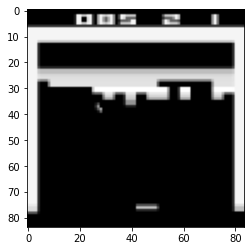

In [28]:
attributions_sq = trajectory_attributions(test_observations, models_sq, trajectory_embedding_seaquest, clusters_seaquest)

In [29]:
attributions_sq

[]

In [30]:
for data_combination_id in result_data_combinations_sq:
    print(f"Data combination {data_combination_id} has {len(result_data_combinations_sq[data_combination_id][0])} actions")

Data combination 0 has 9 actions
Data combination 1 has 9 actions
Data combination 2 has 9 actions
Data combination 3 has 9 actions
Data combination 4 has 9 actions
Data combination 5 has 9 actions
Data combination 6 has 9 actions
Data combination 7 has 9 actions
Data combination 8 has 9 actions


In [31]:
trajectories = attributions_sq[0]['attributed_trajs']
observation = test_observations[0]


IndexError: list index out of range

In [ ]:
data_embedding_original = models_sq[0][1]
data_distances = np.zeros(len(result_data_combinations_sq))
for data_combination_id, (_, action_values_new, data_embedding_new) in result_data_combinations_sq.items(): 
    data_distances[data_combination_id] = wasserstein_distance(data_embedding_original, data_embedding_new)

with np.printoptions(precision=8, suppress=True):
    print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))

[0.         0.00000036 0.00000018 1.         0.00000235 0.01110129
 0.00001413 0.00000417 0.00000054]


In [ ]:
trajectories

[31,
 151,
 192,
 202,
 235,
 241,
 255,
 257,
 262,
 263,
 285,
 316,
 326,
 327,
 398,
 461,
 516,
 551,
 558,
 559,
 634,
 671,
 672,
 675,
 699,
 700,
 717,
 751,
 763,
 764,
 783,
 795,
 797,
 800,
 816,
 859,
 893,
 894,
 904,
 934,
 980,
 981,
 1034,
 1056,
 1063,
 1106,
 1154,
 1155,
 1156,
 1175,
 1204,
 1207,
 1220,
 1243,
 1288,
 1326,
 1333,
 1376,
 1506,
 1566,
 1567,
 1568,
 1582,
 1583,
 1589,
 1640,
 1675]

Trajectory Shape: torch.Size([30, 4, 84, 84])
Trajectory Shape: torch.Size([30, 4, 84, 84])
Trajectory Shape: torch.Size([30, 4, 84, 84])


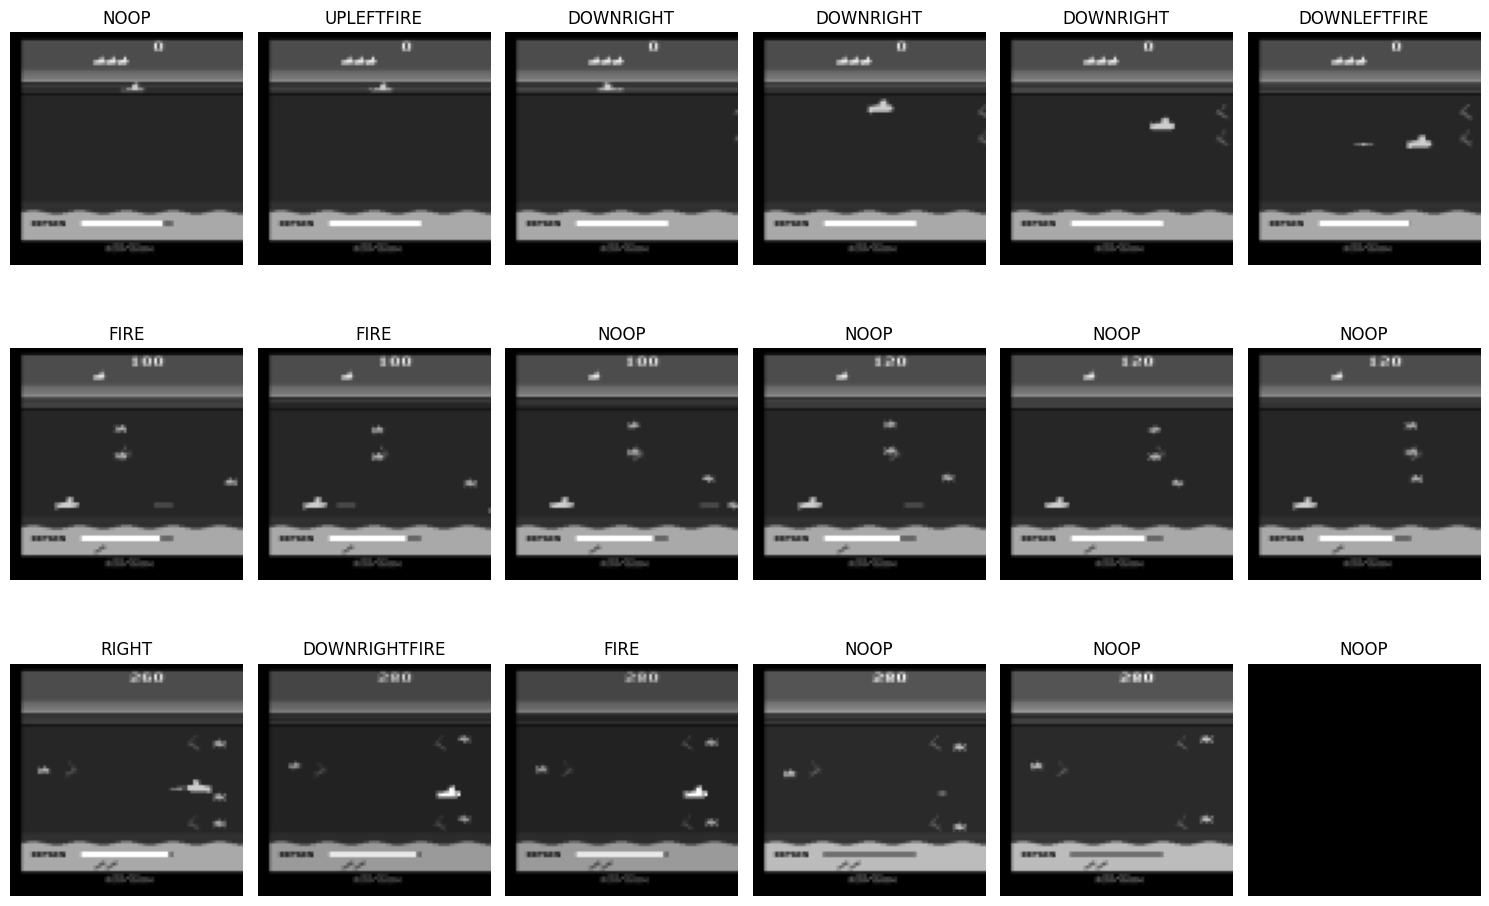

In [ ]:
plt.figure(figsize=(15, 10))

for i, traj in enumerate([31, 151, 192]):
    print("Trajectory Shape:", final_obs_sq[traj].shape)
    # We will plot only the first frame from each stack to avoid consecutive identical frames
    # Assuming every 4th frame is the start of a new stack
    for j in range(0, 30, 4):  # Skip every 4 frames to get to the start of the next stack
        # Calculate the subplot index, but normalize j to reflect that we're skipping frames
        subplot_index = i * (30 // 5) + (j // 5) + 1
        plt.subplot(3, (30 // 5), subplot_index)  
        
        # Plot the first frame from the current stack
        plt.imshow(final_obs_sq[traj][j][0], cmap='gray')

        # Get tensor value as an integer and use it as a key to the action dictionary
        corr_action = int(final_act_sq[traj][j].item())
        # Print the action name on top of each sub-image
        plt.title(action_dict[corr_action])
        plt.axis('off')

plt.tight_layout()
plt.show()